# **Mission of the explainable AI notebook**

You have just trained, tested, and validated classification and regression models to predict the response of retina phenotypes to the RNA-seq features.  Some of your models are promising based on their performance, on the gene set enrichment analysis, and on the pathway enrichment analysis.  But now we wish to know which genes among the RNA-seq features are most predictive of the phenotypes.  This analysis is called feature importance and belongs to a family of techniques called [feature selection](https://en.wikipedia.org/wiki/Feature_selection).  Identifying those genes most predictive of the phenotype provide a molecular target to use for diagnosis, monitoring, and perhaps even prevention of these deleterious phenotypes.  

Your goal is to use various methods that look inside the models you built to determine which features are most important to the model accuracy.  These methods include [impurity](https://en.wikipedia.org/wiki/Random_forest#Mean_Decrease_in_Impurity_Feature_Importance) (for random forest), coefficients []() (for regularized linear regression), [Shapley values](https://en.wikipedia.org/wiki/Shapley_value#In_machine_learning) (for any model), and [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html) (for any model).



# Read in the methods, data, and metadata

## Read in the notebook methods

Recall that we have put all the custom python methods in a separate notebook which you copied to your Google drive.  We need to read those methods into this notebook so that we can use them here.  You will get prompted to select the gmail address to use to permit access to your google drive for this notebook.

Note that we will import the methods in the notebook as "m", so all subsequent references to methods in that notebook will be prefixed with "m.".

In [1]:
# install and import the python module for importing a notebook
!pip install import_ipynb
import import_ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.3 MB/s eta 0:00:00


In [2]:
# mount your google drive to this notebook
from google.colab import drive
drive.flush_and_unmount()
drive.mount("mnt", force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at mnt


In [3]:
# import the "Copy of methods.ipynb" from your google drive into this notebook
m = __import__("mnt/MyDrive/Colab Notebooks/Copy of methods")

importing Jupyter notebook from mnt/MyDrive/Colab Notebooks/Copy of methods.ipynb
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 149.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 132.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 140.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 158.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=8d6da7c2e0e3d6a2cd161eeec53cb5ee96aeb41947636162ac13e5000321f973
  Stored in directory: /tmp/pip-ephem-wheel-cache-35nj7rxm/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.9/552.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s

## Read in the data

After reading in the methods, we need to read in the data from the NASA OSDR space biology data repository.  In this notebook, we will  be using the immunostaining microscopy PECAM data from OSD-568, the RNA-seq data from OSD-255, and the tonometry data from OSD-583.

In [4]:
# define dictionaries for data and metadata
data=dict()
metadata=dict()

In [5]:
# use read_rnaseq_data() to read in the RNA-seq data and read_phenotype_data() to read the tonometry and microscopy data
data['255'] = m.read_rnaseq_data('255_rna_seq_Normalized_Counts')
data['583'] = m.read_phenotype_data('583', 'LSDS-16_tonometry_maoTRANSFORMED')
data['568'] = m.read_phenotype_data('568', 'LSDS-5_immunostaining_microscopy_PECAMtr_TRANSFORMED')

In [6]:
# read in metadata for 255, 568, and 583
metadata['255'] = m.read_meta_data('255')
metadata['568'] = m.read_meta_data('568')
metadata['583'] = m.read_meta_data('583')

# Filter data

After reading in the data from OSDR, we will remove any data that has [missing values](https://pandas.pydata.org/docs/user_guide/missing_data.html). We will reduce the dimensions of the RNA-seq data to include only those genes whose [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) is greater than a threshold. This is a form of [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) that will remove some noise from the gene expression so our classification algorithms can focus on the signal.  We will also filter out [genes that do not code for proteins](https://en.wikipedia.org/wiki/Non-coding_DNA#Noncoding_genes) and those genes that do not have a gene symbol.

shape before filtering:  (23419, 17)
shape after filtering:  (599, 17)


,Unnamed: 0,GSM3932693,GSM3932694,GSM3932695,GSM3932696,GSM3932697,GSM3932698,GSM3932699,GSM3932700,GSM3932701,GSM3932702,GSM3932703,GSM3932704,GSM3932705,GSM3932706,GSM3932707,GSM3932708
30,ENSMUSG00000000215,0.00000,0.000000,0.858363,0.000000,0.000000,3.082389,0.000000,0.0,0.000000,8.524273,0.0,3.400047,0.0,1.797379,0.000000,0.910647
32,ENSMUSG00000000244,0.00000,2.254264,0.888823,7.509906,0.974090,0.000000,0.000000,0.0,3.961715,0.000000,0.0,0.000000,0.0,0.000000,1.326103,0.000000
34,ENSMUSG00000000248,0.00000,0.000000,0.000000,2.766464,0.000000,0.000000,0.000000,0.0,0.000000,3.202214,0.0,0.000000,0.0,0.000000,0.000000,0.000000
57,ENSMUSG00000000359,0.81994,4.607142,0.000000,2.042297,1.629659,0.000000,1.201979,0.0,0.000000,4.254300,0.0,0.000000,0.0,0.000000,0.814021,0.000000
62,ENSMUSG00000000385,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.553946,24.498696,0.0,0.000000,0.0,0.000000,0.000000,0.495085


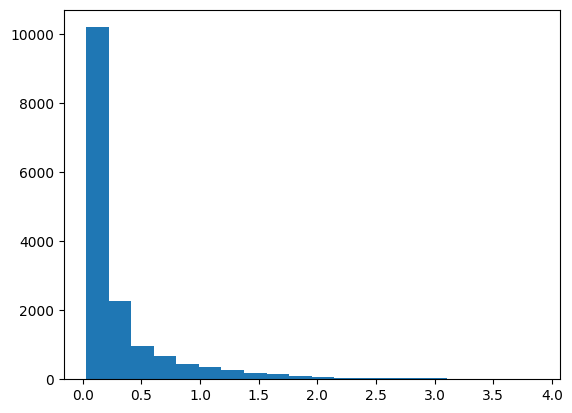

In [7]:
# filter rna_seq to remove nans, non-coding genes, and genes with cv <1.5
rna_seq = data['255']
print('shape before filtering: ', rna_seq.shape)
rna_seq = m.filter_data(rna_seq, dropnans=True, dropgenes='non-coding', droplowcvs=1.5)
print('shape after filtering: ', rna_seq.shape)
rna_seq.head()

In [8]:
# convert gene id to gene symbol and remove any genes that do not have a gene symbol
mg=m.mygene.MyGeneInfo()
ens=list(rna_seq['Unnamed: 0'])
ginfo = mg.querymany(ens, scopes='ensembl.gene')
drop_list=list()
hit_list=list()
for g in ginfo:
    if not 'symbol' in g:
        drop_list.append(g['query'])
    else:
        if not g['symbol'] in hit_list:
            rna_seq.loc[rna_seq['Unnamed: 0']==g['query'], 'Unnamed: 0']=g['symbol']
            hit_list.append(g['symbol'])

print('RNA-seq data shape before: ', rna_seq.shape)
rna_seq = rna_seq[~rna_seq['Unnamed: 0'].isin(drop_list)]
print('RNA-seq data shape after: ', rna_seq.shape)

INFO:biothings.client:querying 1-599...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


RNA-seq data shape before:  (599, 17)
RNA-seq data shape after:  (599, 17)


# Do explainable AI with Shap to predict Pecam threshold from RNA-seq

In this section, we will calculate [Shapley values](https://en.wikipedia.org/wiki/Shapley_value#In_machine_learning) for each feature to determine their predictive importance in the model.  We use a library called [shap](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Iris%20classification%20with%20scikit-learn.html).  We will  compute feature importance using impurity for random forest models and regression coefficients for linear regression.  We will then compare the values calculated by Shap to those more native to the models.

## Explainable random forest with Shap for predicting pecam using RNA-seq

In this section, we build a RF model to predict pecam microscopy values from RNA-seq.  We show the feature importance of the top 20 features for the RF using the impurity measure.  We then calculate the shap values for the features most predictive of the pecam values in the RF model using the held-out test set.  

In [9]:
# get source names from 255 and sample names in immunoMICRO pecam and intersect the lists and subset the df's
samples_both = m.intersect_samples(list(metadata['255']['Source Name']), list(data['568']['Sample_Name']))
print('samples in both datasets: ', samples_both)

samples in both datasets:  ['GC19', 'F18', 'GC15', 'F16', 'F17', 'F20', 'GC16', 'GC17', 'GC18', 'F19', 'F15']


In [10]:
# get GSM sample names from intersection
gsm_samples = list()
for sample in samples_both:
  gsm_name = metadata['255'][metadata['255']['Source Name'] == sample]['Sample Name'].values[0]
  gsm_samples.append(gsm_name)
print('gsm: ', gsm_samples)

gsm:  ['GSM3932699', 'GSM3932706', 'GSM3932695', 'GSM3932704', 'GSM3932705', 'GSM3932708', 'GSM3932696', 'GSM3932697', 'GSM3932698', 'GSM3932707', 'GSM3932703']


In [11]:
# now subset the rna_seq dataframe with samples from the gsm_samples list
X = rna_seq[['Unnamed: 0'] + gsm_samples]
print(X.columns)

Index(['Unnamed: 0', 'GSM3932699', 'GSM3932706', 'GSM3932695', 'GSM3932704',
       'GSM3932705', 'GSM3932708', 'GSM3932696', 'GSM3932697', 'GSM3932698',
       'GSM3932707', 'GSM3932703'],
      dtype='object')


In [12]:
# create numpy array X of rna-seq values
X = m.transpose_df(X, 'Unnamed: 0', 'sample').drop(columns=['sample'])

In [13]:
# create numpy array Y of immuno PECAM values
y = list()
for i in range(len(data['568'])):
  pecam_val=data['568'].iloc[i]['Average']
  y.append(pecam_val)

y = m.np.array(y)
y_classes = list()
for p in y:
  if p > y.mean():
    y_classes.append(1)
  else:
    y_classes.append(0)

y = y_classes
print('y = ', y)

y =  [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0]


In [14]:
# split up data into training and testing subsets
X_train, X_test, y_train, y_test = m.train_test_split(X, y, test_size=0.2, random_state=0)
# show the dimensions of the training and testing data
print('X train: ', X_train.shape)
print('y train: ', len(y_train))
print('X test: ', X_test.shape)
print('y test: ', len(y_test))

X train:  (8, 599)
y train:  8
X test:  (3, 599)
y test:  3


In [15]:
# now run random forest classification on X, y
max_depth=4
rf_classifier = m.RandomForestClassifier(max_depth=max_depth, random_state=23)
rf_classifier.fit(X_train, y_train)

y_train_pred = rf_classifier.predict(X_train)
train_acc = m.accuracy_score(y_train, y_train_pred)
print("train accuracy:", train_acc)

y_pred = rf_classifier.predict(X_test)
accuracy = m.accuracy_score(y_test, y_pred)
print("test accuracy:", accuracy)

train accuracy: 1.0
test accuracy: 0.3333333333333333


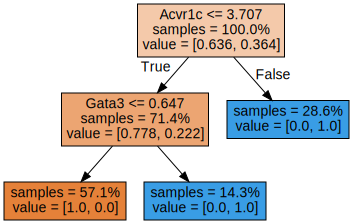

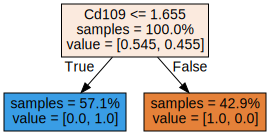

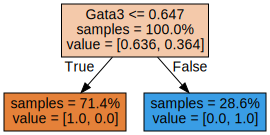

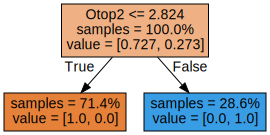

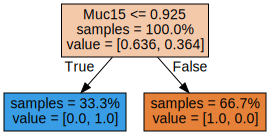

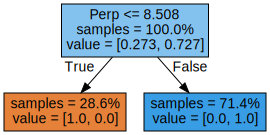

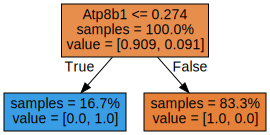

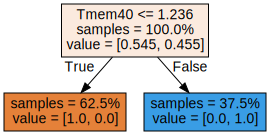

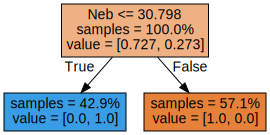

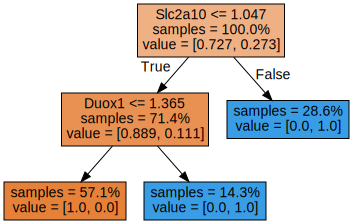

In [16]:
# visualize the random forest
rf_classifier.fit(X, y)
num_trees=10
for i in range(num_trees):
    tree = rf_classifier.estimators_[i]
    dot_data = m.export_graphviz(tree,
                               feature_names=X.columns,
                               filled=True,
                               impurity=False,
                               proportion=True)
    graph = m.graphviz.Source(dot_data)
    display(graph)

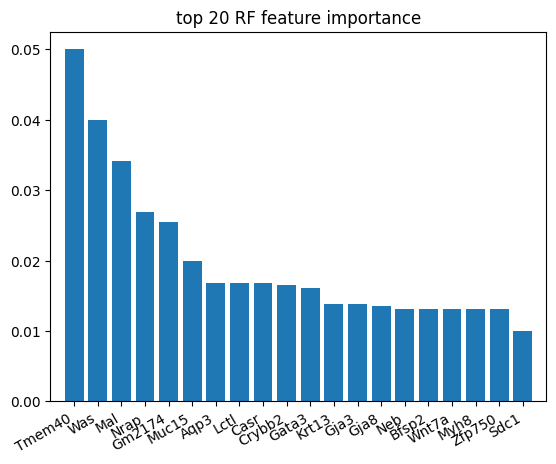

In [17]:
# show top 20 random forest feature importance using the impurity measure
top20_rf_feature_indices = m.np.argsort(rf_classifier.feature_importances_)[::-1][:20]
X_cols = list(X.columns)
top_20_rf_features = list(X.columns[top20_rf_feature_indices])
top_20_rf_feature_importances = rf_classifier.feature_importances_[top20_rf_feature_indices]

m.plt.figure()
m.plt.title("top 20 RF feature importance")
m.plt.bar(range(20), top_20_rf_feature_importances)
m.plt.xticks(range(20), top_20_rf_features, rotation=30, ha='right')
m.plt.xlim([-1, 20])
m.plt.show()

In [18]:
# explain the result of first test example using shap
rf_pred = rf_classifier.predict([X_test.iloc[0]])
print("random forest prediction: ", rf_pred)
print("actual value: ", y_test[0])
explainer = m.shap.KernelExplainer(rf_classifier.predict_proba, X.iloc[0])
shap_values = explainer.shap_values(X_test.iloc[0])
m.shap.initjs()
m.shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X.iloc[0])


random forest prediction:  [1]
actual value:  1


In [19]:
# explain the result of second test example using shap
rf_pred = rf_classifier.predict([X_test.iloc[1]])
print("random forest prediction: ", rf_pred)
print("actual value: ", y_test[1])
explainer = m.shap.KernelExplainer(rf_classifier.predict_proba, X_train.iloc[1])
shap_values = explainer.shap_values(X_test.iloc[1])
m.shap.initjs()
m.shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test.iloc[1])


random forest prediction:  [0]
actual value:  0


In [20]:
# explain the result of third test example using shap
rf_pred = rf_classifier.predict([X_test.iloc[2]])
print("random forest prediction: ", rf_pred)
print("actual value: ", y_test[2])
explainer = m.shap.KernelExplainer(rf_classifier.predict_proba, X_train.iloc[2])
shap_values = explainer.shap_values(X_test.iloc[2])
m.shap.initjs()
m.shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test.iloc[2])


random forest prediction:  [0]
actual value:  0


**QUESTIONS**

1. Which genes appeared in both the visualization of the random forest as well as the top 20 feature importance using the impurity measure?

2. Do any of the genes from question #1 also appear in the shapley value analysis for the first, second, or third test example?

3.

**Double click here to enter your answers to the questions above.**

1.

2.

3.

## Explainable logistic regression with Shap for predicting pecam using RNA-seq

In this section, we build a LR model to predict pecam microscopy values from RNA-seq.  We show the feature importance of the top 20 features for the LR using the coefficients of the regression.  We then calculate the shap values for the features most predictive of the pecam values in the LR model using the held-out test set.  

In [21]:
# now run logistic regression classification on X, y

lr_classifier = m.LogisticRegression(random_state=23)
lr_classifier.fit(X_train, y_train)

y_train_pred = lr_classifier.predict(X_train)
train_acc = m.accuracy_score(y_train, y_train_pred)
print("train accuracy:", train_acc)

y_pred = lr_classifier.predict(X_test)
test_acc = m.accuracy_score(y_test, y_pred)
print("test accuracy:", test_acc)

train accuracy: 1.0
test accuracy: 0.3333333333333333


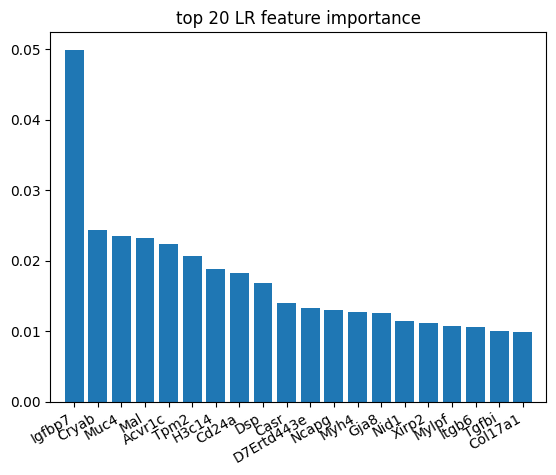

In [22]:
# find highest coefficients in model
lr_classifier.fit(X, y)
top20_lr_feature_indices = m.np.argsort(lr_classifier.coef_[0])[::-1][:20]
X_cols = list(X.columns)
top_20_lr_features = [X.columns[i] for i in top20_lr_feature_indices]
top_20_lr_feature_importances = lr_classifier.coef_[0][top20_lr_feature_indices]


m.plt.figure()
m.plt.title("top 20 LR feature importance")
m.plt.bar(range(20), top_20_lr_feature_importances)
m.plt.xticks(range(20), top_20_lr_features, rotation=30, ha='right')
m.plt.xlim([-1, 20])
m.plt.show()

In [23]:
# explain the result of first test example using shap
lr_pred = lr_classifier.predict([X_test.iloc[0]])
print("logistic regression prediction: ", lr_pred)
print("actual value: ", y_test[0])
explainer = m.shap.KernelExplainer(lr_classifier.predict_proba, X_train.iloc[0])
shap_values = explainer.shap_values(X_test.iloc[0])
m.shap.initjs()
m.shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test.iloc[0])


logistic regression prediction:  [1]
actual value:  1


In [24]:
# explain the result of second test example using shap
lr_pred = lr_classifier.predict([X_test.iloc[1]])
print("logistic regression prediction: ", lr_pred)
print("actual value: ", y_test[1])
explainer = m.shap.KernelExplainer(lr_classifier.predict_proba, X_train.iloc[1])
shap_values = explainer.shap_values(X_test.iloc[1])
m.shap.initjs()
m.shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test.iloc[1])


logistic regression prediction:  [0]
actual value:  0


In [25]:
# explain the result of third test example using shap
lr_pred = lr_classifier.predict([X_test.iloc[2]])
print("logistic regression prediction: ", lr_pred)
print("actual value: ", y_test[2])
explainer = m.shap.KernelExplainer(lr_classifier.predict_proba, X_train.iloc[2])
shap_values = explainer.shap_values(X_test.iloc[2])
m.shap.initjs()
m.shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test.iloc[2])


logistic regression prediction:  [0]
actual value:  0


**QUESTIONS**


1. For the first test sample, which gene is the most important in bringing the logistic regression value to 0?

2. For the second test sample, which gene is the most important in bringing the logistic regression value to 1?

3. For the third test sample, of the genes most important in bringing the logistic regression value to 1, which belong to the top 20 largest logistic regression coefficients?

**Double click here to enter your answers to the questions above.**

1.

2.

3.

## Compare random forest and logistic regression native feature importance

In this last section using Shap, we compare the top 20 features most predictive of the pecam microscopy values from RNA-seq between the RF model and the LR model.  Since they are on different scales, we need to first normalize the LR coefficients and RF feature importances to be on the [0, 1] scale to compare directly.

In [26]:
# scale logistic regression and random forest feature importances to [0,1] scale for comparison
max=1
min=0
# first scale LR coefs
LR_std = (lr_classifier.coef_ - lr_classifier.coef_.min()) / (lr_classifier.coef_.max() - lr_classifier.coef_.min())
LR_scaled = list(LR_std * (max - min) + min)[0]

# second scale RF feature importances
RF_std = (rf_classifier.feature_importances_- rf_classifier.feature_importances_.min()) / (rf_classifier.feature_importances_.max() - rf_classifier.feature_importances_.min())
RF_scaled = list(RF_std * (max - min) + min)

In [27]:
# create and display a dataframe showing top 20 logistic regression feature importances in descending order and corresponding random forest feature importance

feat_imp_df = m.pd.DataFrame( {
    'feature': X.columns,
    'lr_feature_imp': LR_scaled,
    'rf_feature_imp': RF_scaled
})

feat_imp_df = feat_imp_df.sort_values('lr_feature_imp', ascending=False)
feat_imp_df.head(20).style.format(
    '{:.2f}', subset=['lr_feature_imp', 'rf_feature_imp']).bar(subset=['lr_feature_imp', 'rf_feature_imp'], color='#3776ab', width=60)

,feature,lr_feature_imp,rf_feature_imp
268,Igfbp7,1.00,0.00
226,Cryab,0.77,0.00
598,Muc4,0.76,0.00
147,Mal,0.76,0.68
137,Acvr1c,0.75,0.08
161,Tpm2,0.73,0.13
545,H3c14,0.72,0.00
355,Cd24a,0.71,0.13
406,Dsp,0.70,0.00
390,Casr,0.67,0.34


In [28]:
# create and display a dataframe showing top 20 random forest feature importances in descending order and corresponding logistic regression feature importance

feat_imp_df = m.pd.DataFrame( {
    'feature': X.columns,
    'rf_feature_imp': RF_scaled,
        'lr_feature_imp': LR_scaled
})

feat_imp_df = feat_imp_df.sort_values('rf_feature_imp', ascending=False)
feat_imp_df.head(20).style.format(
    '{:.2f}', subset=['rf_feature_imp', 'lr_feature_imp']).bar(subset=['rf_feature_imp', 'lr_feature_imp'], color='#3776ab', width=60)

,feature,rf_feature_imp,lr_feature_imp
436,Tmem40,1.00,0.58
212,Was,0.80,0.60
147,Mal,0.68,0.76
370,Nrap,0.54,0.47
429,Gm2174,0.51,0.55
383,Muc15,0.40,0.53
159,Aqp3,0.34,0.53
390,Casr,0.34,0.67
233,Lctl,0.34,0.58
319,Crybb2,0.33,0.62


**QUESTIONS**

1. Based on the first graph in this section, what is the most important feature of the logistic regression model?

2. Based on the second graph in this section, what is the most important feature of the random forest model?

3. Is there any overlap between the scaled feature importance of the logistic regression model and the random forest model?

**Double click here to enter your answers to the questions above.**

1.

2.

3.

# Do explainable AI with permutation feature importance and linear regression

In this section, we will calculate [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html) for each feature to determine their predictive importance in the model using scikit-learn's implementation. We will compare the permutation feature importance results with the regularized linear regression coefficients (using [Ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)).

## Find genes most predictive of IOP value using feature permutation and regularized linear regression

Here we use regularized linear regression to predict the IOP response to the RNA-seq features and then examine that model to ascertain which features are most important.  

In [29]:
# initialize X to rna_seq
X = rna_seq
X.head()

,Unnamed: 0,GSM3932693,GSM3932694,GSM3932695,GSM3932696,GSM3932697,GSM3932698,GSM3932699,GSM3932700,GSM3932701,GSM3932702,GSM3932703,GSM3932704,GSM3932705,GSM3932706,GSM3932707,GSM3932708
30,Ins2,0.00000,0.000000,0.858363,0.000000,0.000000,3.082389,0.000000,0.0,0.000000,8.524273,0.0,3.400047,0.0,1.797379,0.000000,0.910647
32,Tspan32,0.00000,2.254264,0.888823,7.509906,0.974090,0.000000,0.000000,0.0,3.961715,0.000000,0.0,0.000000,0.0,0.000000,1.326103,0.000000
34,Clec2g,0.00000,0.000000,0.000000,2.766464,0.000000,0.000000,0.000000,0.0,0.000000,3.202214,0.0,0.000000,0.0,0.000000,0.000000,0.000000
57,Rem1,0.81994,4.607142,0.000000,2.042297,1.629659,0.000000,1.201979,0.0,0.000000,4.254300,0.0,0.000000,0.0,0.000000,0.814021,0.000000
62,Tmprss2,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.553946,24.498696,0.0,0.000000,0.0,0.000000,0.000000,0.495085


In [30]:
# we need to intersect the OSD-255 (RNA-seq) and OSD-583 (IOP) samples for comparison
samples_both = m.intersect_samples(list(metadata['255']['Source Name']), list(data['583']['Source Name']))
samples_both

['GC19',
 'F18',
 'GC15',
 'F9',
 'F16',
 'GC9',
 'F11',
 'GC20',
 'F17',
 'F20',
 'GC17',
 'GC16',
 'GC11',
 'GC18',
 'F19',
 'F15']

In [31]:
# subset samples in 583 with samples from 255 (OSD-255 samples are a proper subset of those samples in OSD-583)
samples=list()
for sample in rna_seq.columns[1:]:
  samples.append(metadata['255'][metadata['255']['Sample Name']==sample]['Source Name'].values[0])
samples_short=list()
for sample in samples:
  num = ""
  for c in sample:
    if c.isdigit():
      num += str(c)
  if 'G' in sample:
    samples_short.append("GC" + num)
  elif 'F' in sample:
    samples_short.append("F" + num)
iop_df=data['583'][data['583']['Source Name'].isin(samples_short)]
iop_df.head()

,Source Name,Sample Name,Factor Value: Spaceflight,Left_1,Left_2,Left_3,Avg_Left,Right_1,Right_2,Right_3,Avg_Right,time_Start,Time_End
8,F9,F9_Mouse_Eye,Space Flight,14,13,12,13.000000,14,12,12,13.000000,2:11,2:13
10,F11,F11_Mouse_Eye,Space Flight,15,16,18,16.333333,16,14,15,15.000000,2:23,2:27
14,F15,F15_Mouse_Eye,Space Flight,20,19,19,19.333333,17,17,16,16.666667,2:48,2:51
15,F16,F16_Mouse_Eye,Space Flight,19,20,18,19.000000,21,18,17,18.666667,3:07,3:09
16,F17,F17_Mouse_Eye,Space Flight,18,19,18,18.333333,16,17,15,16.000000,3:03,3:05


In [32]:
# create numpy array Y of iop values
y = list()
for i in range(len(iop_df)):
  iop_val=(iop_df.iloc[i]['Avg_Left'] + iop_df.iloc[i]['Avg_Right'])/2
  y.append(iop_val)
y = m.np.array(y)
print(y)

[13.         15.66666666 18.         18.83333333 17.16666667 18.
 19.         18.5        18.5        21.16666667 19.5        17.5
 21.66666667 17.83333333 20.66666667 16.16666667]


In [33]:
# create numpy array X of rna-seq values
X = m.transpose_df(X, 'Unnamed: 0', 'sample').drop(columns=['sample'])
X.head()

,Ins2,Tspan32,Clec2g,Rem1,Tmprss2,Cryba1,Vpreb3,Ccl3,Slc13a2,Ftcd,...,Gcat,Atp5po,Gm17266,Asdurf,Gm50318,Wdr88,Gm44505,Nrg1,Lim2,Muc4
0,0.000000,0.000000,0.000000,0.819940,0.0,4.704395,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.349993,2.135908
1,0.000000,2.254264,0.000000,4.607142,0.0,14422.355049,0.000000,0.946336,1.892577,0.000000,...,0.0,0.000000,1.892584,0.000000,1.892626,2.838880,0.000000,5.680657,380.423140,174.561060
2,0.858363,0.888823,0.000000,0.000000,0.0,691.367545,0.767724,2.514871,0.000000,0.000000,...,0.0,2.514927,0.000000,8.383695,0.000000,0.000000,36.045317,1.677031,13.412562,2.286296
3,0.000000,7.509906,2.766464,2.042297,0.0,13.668093,0.000000,0.000000,6.827896,0.000000,...,0.0,0.000000,0.000000,0.000000,5.852506,0.000000,0.000000,1.950985,0.000000,805.759529
4,0.000000,0.974090,0.000000,1.629659,0.0,112.183085,1.069251,0.000000,0.000000,1.547025,...,0.0,0.000000,5.837501,0.000000,0.000000,5.837507,12.842437,2.335692,0.000000,18.044066


In [34]:
# split up data between training and testing
X_train, X_test, y_train, y_test = m.train_test_split(X, y, test_size=0.2, random_state=0)
# show the dimensions of the training and testing data
print('X train: ', X_train.shape)
print('y train: ', len(y_train))
print('X test: ', X_test.shape)
print('y test: ', len(y_test))

X train:  (12, 599)
y train:  12
X test:  (4, 599)
y test:  4


In [35]:
# now run linear regression on X, y
#linreg = m.LinearRegression().fit(X_train, y_train)
linreg = m.Ridge(alpha=1.0)
linreg.fit(X_train, y_train)
print('training score: ', linreg.score(X_train, y_train))
print('testing score: ', linreg.score(X_test, y_test))

training score:  0.9999999978813852
testing score:  -179.67827422199383


In [36]:
# get y_pred and and compare against the actual values of y
y_pred = linreg.predict(X_test)
pred = m.pd.DataFrame({'True_value': y_test, 'Predicted': y_pred})
pred

,True_value,Predicted
0,15.666667,39.052033
1,19.000000,18.717125
2,18.500000,18.595494
3,21.166667,68.373176


In [37]:
# find largest (pos or neg) coefficients in model (a crude approximation to feature importance) based on all samples
#linreg = m.LinearRegression().fit(X, y)
linreg = m.Ridge(alpha=1.0)
linreg.fit(X_train, y_train)
sorted_linreg_feature_indices = m.np.argsort(-1 * abs(linreg.coef_))
X_cols = list(rna_seq['Unnamed: 0'])
sorted_linreg_features = [rna_seq.iloc[i]['Unnamed: 0'] for i in sorted_linreg_feature_indices]
feat_imp_df = m.pd.DataFrame( {
    'feature': sorted_linreg_features,
    'linreg coef': [linreg.coef_[i] for i in sorted_linreg_feature_indices]#m.np.argsort(abs(linreg.coef_))[-20:] *100
})

feat_imp_df.head(20)

,feature,linreg coef
0,Wdfy4,-0.016389
1,Cryab,0.015559
2,Col4a1,0.011688
3,Cd24a,-0.011416
4,Col6a3,0.010268
5,Cryaa,-0.009120
6,Ttpa,-0.006352
7,Hhipl2,-0.006051
8,Tgtp2,-0.005943
9,Cpz,-0.005930


In [38]:
# use sklearn permutation_importance on entire dataset
r = m.permutation_importance(linreg, X, y, n_repeats=5, random_state=23)
# identify up to top 20 most important features
genes = list()
means = list()
stds = list()
mins = list()
maxes = list()
for i in r.importances_mean.argsort()[::-1][:20]:
  if r.importances_mean[i] -2 * r.importances_std[i] > 0:
    #print(X.columns[i], round(r.importances_mean[i], 2), round(r.importances_std[i], 2))
    genes.append(X.columns[i])
    means.append(round(r.importances_mean[i], 2))
    stds.append(round(r.importances_std[i], 2))
    mins.append(r.importances[i].min())
    maxes.append(r.importances[i].max())

feat_imp_df = m.pd.DataFrame( {
    'feature': genes,
    'importance_mean': means,
    'importance_std': stds
})

feat_imp_df.sort_values(by=['importance_mean'], ascending=False).head(20)

,feature,importance_mean,importance_std
0,Cryaa,8526.26,241.70
1,Cryab,4612.15,133.99
2,Crybb2,179.72,13.25
3,Cryba1,59.21,1.50
4,Col4a1,21.51,2.90
5,Crygs,17.16,3.62
6,Cd24a,15.40,0.85
7,Mip,10.55,0.31
8,Ttn,4.65,1.98
9,Nid1,2.59,0.06


<ErrorbarContainer object of 3 artists>

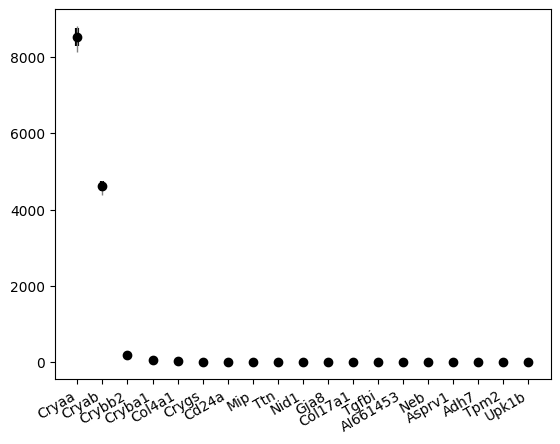

In [39]:
# create stacked errorbars:
m.plt.errorbar(genes, means, stds, fmt='ok', lw=3)
means_minus_mins = [mean_i - min_i for mean_i, min_i in zip(means, mins)]
maxes_minus_means = [max_i - mean_i for max_i, mean_i in zip(maxes, means)]
m.plt.xticks(rotation=30, ha='right')
m.plt.errorbar(genes, means, [means_minus_mins, maxes_minus_means], fmt='.k', ecolor='gray', lw=1)

**QUESTIONS**

1. How many samples were used for training and testing?

2. Which genes overlap as the most important features when using the linear regression coefficients and the permutation feature importance?

3. Based on the stacked errorbars plot, which 2 genes are the most predictive of the IOP value?

**Double click here to enter your answers to the questions above.**

1.

2.

3.

## Find genes most predictive of PECAM microscopy value using feature permutation and regularized linear regression

Here we use regularized linear regression to predict the PECAM microscopy response to the RNA-seq features and then examine that model to ascertain which features are most important.  

In [40]:
# initialize X to rna_seq
X = rna_seq
X.head()

,Unnamed: 0,GSM3932693,GSM3932694,GSM3932695,GSM3932696,GSM3932697,GSM3932698,GSM3932699,GSM3932700,GSM3932701,GSM3932702,GSM3932703,GSM3932704,GSM3932705,GSM3932706,GSM3932707,GSM3932708
30,Ins2,0.00000,0.000000,0.858363,0.000000,0.000000,3.082389,0.000000,0.0,0.000000,8.524273,0.0,3.400047,0.0,1.797379,0.000000,0.910647
32,Tspan32,0.00000,2.254264,0.888823,7.509906,0.974090,0.000000,0.000000,0.0,3.961715,0.000000,0.0,0.000000,0.0,0.000000,1.326103,0.000000
34,Clec2g,0.00000,0.000000,0.000000,2.766464,0.000000,0.000000,0.000000,0.0,0.000000,3.202214,0.0,0.000000,0.0,0.000000,0.000000,0.000000
57,Rem1,0.81994,4.607142,0.000000,2.042297,1.629659,0.000000,1.201979,0.0,0.000000,4.254300,0.0,0.000000,0.0,0.000000,0.814021,0.000000
62,Tmprss2,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.553946,24.498696,0.0,0.000000,0.0,0.000000,0.000000,0.495085


In [41]:
# get source names from 255 and sample names in immunoMICRO pecam and intersect the lists and subset the df's
samples_both = m.intersect_samples(list(metadata['255']['Source Name']), list(data['568']['Sample_Name']))

# get GSM sample names from intersection
gsm_samples = list()
for sample in samples_both:
  gsm_name = metadata['255'][metadata['255']['Source Name'] == sample]['Sample Name'].values[0]
  gsm_samples.append(gsm_name)

# now subset the rna_seq dataframe with samples from the gsm_samples list
X = X[['Unnamed: 0'] + gsm_samples]
print(X.columns)

Index(['Unnamed: 0', 'GSM3932699', 'GSM3932706', 'GSM3932695', 'GSM3932704',
       'GSM3932705', 'GSM3932708', 'GSM3932696', 'GSM3932697', 'GSM3932698',
       'GSM3932707', 'GSM3932703'],
      dtype='object')


In [42]:
# create numpy array X of rna-seq values
X = m.transpose_df(X, 'Unnamed: 0', 'sample').drop(columns=['sample'])
X.head()

,Ins2,Tspan32,Clec2g,Rem1,Tmprss2,Cryba1,Vpreb3,Ccl3,Slc13a2,Ftcd,...,Gcat,Atp5po,Gm17266,Asdurf,Gm50318,Wdr88,Gm44505,Nrg1,Lim2,Muc4
0,0.000000,0.000000,0.0,1.201979,0.0,417.993398,0.000000,0.861072,1.722240,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,6.027574,48.539682
1,1.797379,0.000000,0.0,0.000000,0.0,1755.408794,0.000000,0.000000,0.877773,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.043985,16.758689
2,0.858363,0.888823,0.0,0.000000,0.0,691.367545,0.767724,2.514871,0.000000,0.000000,...,0.000000,2.514927,0.000000,8.383695,0.000000,0.0,36.045317,1.677031,13.412562,2.286296
3,3.400047,0.000000,0.0,0.000000,0.0,162.864565,0.000000,0.000000,0.000000,2.200243,...,0.000000,0.000000,1.106968,0.000000,3.320854,0.0,0.000000,0.000000,5.534704,23.642643
4,0.000000,0.000000,0.0,0.000000,0.0,27.926024,5.807310,0.000000,0.000000,0.000000,...,3.804933,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.268250,12.684364


In [43]:
# create numpy array Y of immuno PECAM values
y = list()
for i in range(len(data['568'])):
  pecam_val=data['568'].iloc[i]['Average']
  y.append(pecam_val)

y = m.np.array(y)
print('y = ', y)

y =  [45.0098 53.9888 37.0548 67.0988 49.7456 43.2828 37.771  38.1888 25.5472
 38.0384 36.8556]


In [44]:
# split up data between training and testing
X_train, X_test, y_train, y_test = m.train_test_split(X, y, test_size=0.2, random_state=0)
# show the dimensions of the training and testing data
print('X train: ', X_train.shape)
print('y train: ', len(y_train))
print('X test: ', X_test.shape)
print('y test: ', len(y_test))

X train:  (8, 599)
y train:  8
X test:  (3, 599)
y test:  3


In [45]:
# now run linear regression on X, y
#linreg = m.LinearRegression().fit(X_train, y_train)
linreg = m.Ridge(alpha=1.0)
linreg.fit(X_train, y_train)
print('training score: ', linreg.score(X_train, y_train))
print('testing score: ', linreg.score(X_test, y_test))

training score:  0.9999999994261835
testing score:  -2.0681172540595845


In [46]:
# get y_pred and and compare against the actual values of y
y_pred = linreg.predict(X_test)
pred = m.pd.DataFrame({'True_value': y_pred, 'Predicted': y_test})
pred

,True_value,Predicted
0,40.062394,49.7456
1,44.973068,38.0384
2,49.861798,37.0548


In [47]:
# find largest (pos or neg) coefficients in model (a crude approximation to feature importance)
#linreg = m.LinearRegression().fit(X, y)
linreg = m.Ridge(alpha=1.0)
linreg.fit(X_train, y_train)
sorted_linreg_feature_indices = m.np.argsort(-1 * abs(linreg.coef_))
X_cols = list(rna_seq['Unnamed: 0'])
sorted_linreg_features = [rna_seq.iloc[i]['Unnamed: 0'] for i in sorted_linreg_feature_indices]
feat_imp_df = m.pd.DataFrame( {
    'feature': sorted_linreg_features,
    'linreg_coef': [linreg.coef_[i] for i in sorted_linreg_feature_indices]
})

feat_imp_df.head(20)

,feature,linreg_coef
0,Myh4,0.076647
1,Ttn,-0.054057
2,Col4a1,-0.051687
3,Atp2a1,0.030698
4,Tpm2,0.028347
5,Mal,0.022372
6,Fam177a2,-0.020265
7,Cryab,-0.018892
8,Mip,0.015797
9,Cryba1,-0.015793


In [48]:
# use sklearn permutation_importance on entire dataset
r = m.permutation_importance(linreg, X, y, n_repeats=5, random_state=23)
# identify up to top 20 most important features
genes = list()
means = list()
stds = list()
mins=list()
maxes=list()
for i in r.importances_mean.argsort()[::-1][:20]:
  if r.importances_mean[i] -2 * r.importances_std[i] > 0:
    #print(X.columns[i], round(r.importances_mean[i], 2), round(r.importances_std[i], 2))
    genes.append(X.columns[i])
    means.append(round(r.importances_mean[i], 2))
    stds.append(round(r.importances_std[i], 2))
    mins.append(r.importances[i].min())
    maxes.append(r.importances[i].max())

feat_imp_df = m.pd.DataFrame( {
    'feature': genes,
    'importance_mean': means,
    'importance_std': stds
})

feat_imp_df.sort_values(by=['importance_mean'], ascending=False).head(20)

,feature,importance_mean,importance_std
0,Ttn,74.78,3.19
1,Myh4,12.16,0.87
2,Atp2a1,1.44,0.28
3,Muc4,0.36,0.14
4,Gsto1,0.35,0.13
5,Myh3,0.21,0.10
6,Fam177a2,0.14,0.04


Text(0.5, 1.0, 'stacked error bars for top 20 permutation feature importance')

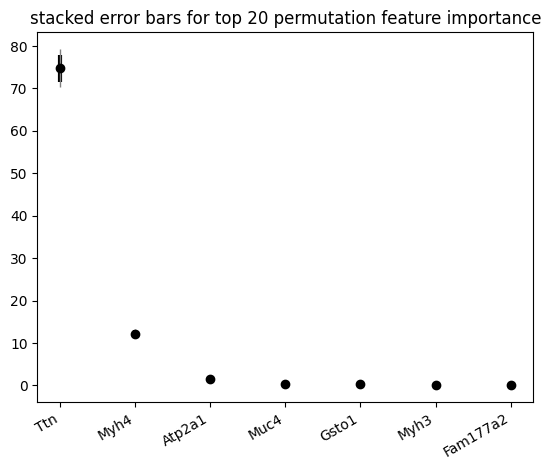

In [49]:
# create stacked errorbars:
m.plt.errorbar(genes, means, stds, fmt='ok', lw=3)
means_minus_mins = [abs(mean_i - min_i) for mean_i, min_i in zip(means, mins)]
maxes_minus_means = [abs(max_i - mean_i) for max_i, mean_i in zip(maxes, means)]
m.plt.xticks(rotation=30, ha='right')
m.plt.errorbar(genes, means, [means_minus_mins, maxes_minus_means],fmt='.k', ecolor='gray', lw=1)
m.plt.title("stacked error bars for top 20 permutation feature importance")

**QUESTIONS**

1. How many samples were used for training and testing?

2. Which genes overlap as the most important features when using the linear regression coefficients and the permutation feature importance?

3. Based on the stacked errorbars plot, which 3 genes are the most predictive of the IOP value?


**Double click here to enter your answers to the questions above.**

1.

2.

3.